In [17]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import re

In [18]:
# Constants
mu = 4.282837e4  # Mars' gravitational parameter, km^3/s^2
radius = 3389.5  # Mars' mean radius, km
h_0 = 255  # Orbital altitude at periapsis, km
r_0 = h_0 + radius  # Periapsis radius, km
eccentricity = 0.005  # Orbital eccentricity

semi_major_axis = r_0 / (1 - eccentricity)
v_0 = np.sqrt(mu * (2 / r_0 - 1 / semi_major_axis))

In [19]:
def extract_ephemeris_data(file_path):
    times = []
    positions = []
    velocities = []

    try:
        with open(file_path, 'r') as file:
            lines = file.readlines()

        recording = False
        for line in lines:
            line = line.strip()
            if "$$SOE" in line:
                recording = True
                continue
            if "$$EOE" in line:
                break
            if not recording:
                continue

            # Extract Julian time
            if "=" in line and line.split()[0].replace(".", "").isdigit():
                times.append(float(line.split()[0]))

            # Extract position data
            if "X =" in line:
                match = re.findall(r"[-+]?\d*\.\d+E[+-]?\d+", line)
                if len(match) == 3:
                    positions.append(list(map(float, match)))

            # Extract velocity data
            if "VX=" in line:
                match = re.findall(r"[-+]?\d*\.\d+E[+-]?\d+", line)
                if len(match) == 3:
                    velocities.append(list(map(float, match)))

        return np.array(times), np.array(positions), np.array(velocities)
    except Exception as e:
        print(f"Error reading file: {e}")
        return np.array([]), np.array([]), np.array([])

In [20]:
# Load the ephemeris data
file_path = "horizons_results.txt"
julian_times, real_positions, real_velocities = extract_ephemeris_data(file_path)

# Ensure data is valid
if len(julian_times) == 0:
    raise ValueError("No ephemeris data extracted. Please check the file.")

In [21]:
initial_position = real_positions[0]
initial_velocity = real_velocities[0]
initial_Y_0 = np.hstack((initial_position, initial_velocity))
print(initial_Y_0)

[ 1.74256275e+02  8.88988155e+02 -3.51456511e+03 -8.67541783e-02
 -3.33953363e+00 -8.40846213e-01]


In [22]:
# Initial state vector
r_vec = np.array([0, 0, r_0])
v_vec = np.array([0, v_0, 0])
Y_0 = np.hstack((r_vec, v_vec))

In [23]:
# Orbital period
orbital_period = 2 * np.pi * np.sqrt(semi_major_axis**3 / mu)
print(orbital_period/60) # orbital period [min]

# Integral
t_0 = 0
t_f = orbital_period
step_size = 1001
t_points = np.linspace(t_0, t_f, step_size)

112.17217884202189


In [24]:
def relative_motion(t, Y):
    r_vec = Y[:3]

    Ydot = np.zeros_like(Y)
    Ydot[:3] = Y[3:]

    r = np.sqrt(np.sum(np.square(r_vec)))
    a_vec = -mu * r_vec / r**3
    Ydot[3:] = a_vec

    return Ydot

In [25]:
sol = solve_ivp(relative_motion,
                [t_0, t_f],
                Y_0,
                t_eval=t_points,
                method = "RK45",
                rtol=1e-8,
                atol=1e-8
)

Y = sol.y.T
r = Y[:, :3]  # km
v = Y[:, 3:]  # km

In [26]:
r_mag = np.sqrt(np.sum(np.square(r), axis=1))
# altitude is the distance above the surface of the Earth
altitude = r_mag - radius

speed = np.sqrt(np.sum(np.square(v), axis=1))

In [27]:
min_altitude = np.min(altitude)
i_min = np.argmin(altitude)

max_altitude = np.max(altitude)
i_max = np.argmax(altitude)

speed_at_min_alt = speed[i_min]
speed_at_max_alt = speed[i_max]
time_at_min_alt = sol.t[i_min]
time_at_max_alt = sol.t[i_max]

In [28]:
print(
    f"""\
The minimum altitude during the orbit is: {min_altitude:.2F} km
The speed at the minimum altitude is: {speed_at_min_alt:.2F} km/s
The time at minimum altitude is: {time_at_min_alt:.2F} s
The maximum altitude during the orbit is: {max_altitude:.2F} km
The velocity at the maximum altitude is: {speed_at_max_alt:.4F} km/s
The time at maximum altitude is: {time_at_max_alt:.2F} s
"""
)

The minimum altitude during the orbit is: 255.00 km
The speed at the minimum altitude is: 3.44 km/s
The time at minimum altitude is: 0.00 s
The maximum altitude during the orbit is: 291.63 km
The velocity at the maximum altitude is: 3.4024 km/s
The time at maximum altitude is: 3365.17 s



In [29]:
def calculate_rmse(simulated, real):
    errors = np.sqrt(np.sum((simulated - real) ** 2, axis=1))  # Distancia euclidiana en cada paso
    return np.sqrt(np.mean(errors))  # RMSE final como un solo número

rmse_positions = calculate_rmse(r, real_positions)

In [30]:
# Write results to output.txt
output_file = "output.txt"
with open(output_file, "w") as f:
    f.write(f"RMSE for positions: {rmse_positions:.6f} km\n")
    f.write("Simulated Positions vs. Real Positions:\n")
    for sim_pos, real_pos in zip(r, real_positions):
        f.write(f"Simulated: {sim_pos}, Real: {real_pos}, Error: {np.sqrt(np.sum((sim_pos - real_pos) ** 2))}\n")

print(f"Results written to {output_file}")

Results written to output.txt


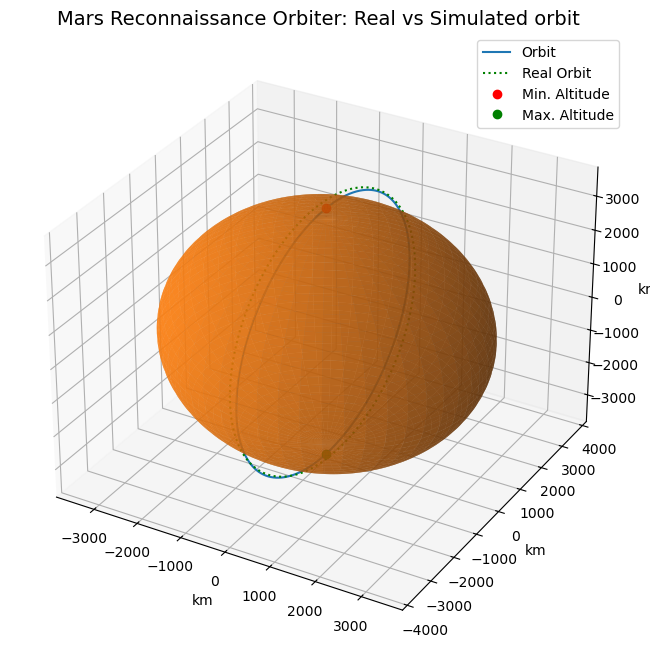

In [31]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")
ax.plot(r[:, 0], r[:, 1], r[:, 2], label="Orbit")
ax.set_xlabel("km")
ax.set_ylabel("km")
ax.set_zlabel("km")

# This adds a sphere to the plot of the radius of the Mars
p = np.linspace(0, np.pi, 200)
t = np.linspace(0, 2 * np.pi, 200)
P, T = np.meshgrid(p, t)

scale = 1
X = scale * radius * np.cos(T) * np.sin(P)
Y = scale * radius * np.sin(T) * np.sin(P)
Z = scale * radius * np.cos(P)

real_x, real_y, real_z = real_positions.T
ax.plot(real_x, real_y, real_z, label="Real Orbit", color="green", linestyle="dotted")

ax.set_title("Mars Reconnaissance Orbiter: Real vs Simulated orbit", fontsize=14)
ax.plot_surface(X, Y, Z, alpha=0.7)
ax.plot(r[i_min, 0], r[i_min, 1], r[i_min, 2], "ro", label="Min. Altitude")
ax.plot(r[i_max, 0], r[i_max, 1], r[i_max, 2], "go", label="Max. Altitude")
ax.legend()